In [22]:
### Algorithms 1, 2 in OPTIMA_2021 and new subgradient algorithm (2.1) in the paper to Math. Notes

import math
from datetime import datetime

import numpy as np
from scipy.optimize import minimize

In [23]:
n = 1000      # the dimension of the problem
p = 2         # this parameter in the prox function and Bregman divergence
M = 1         # f is M-relative Lipschitz
a = 0.2       # this is the upper boud of the cube Q = [-a,a]^n
mu = (p-1)/((2*p-1)*(np.power(a*math.sqrt(n),p)))
print ('mu =' , mu)

mu = 0.008333333333333331


In [3]:
# ### projection on to the cube {x, -a <= x[i] <= a}
# def proj_cube(x):
#     for i in range(len(x)):
#         if x[i] < -1*a:
#             x[i] = -1*a
#         elif x[i]> a:
#             x[i] = a
#     return np.array(x)

In [32]:
### the objective function. 1-relative Lipschitz and strongly relative
def f(x):
    return (1/p)*(np.power(np.linalg.norm(x), p)) 

### operator g = the gradient of the function f: grad(f)=g(x)
def g(x):
    return (np.linalg.norm(x) ** (p - 2)) * x
    # return np.multiply(np.power(np.linalg.norm(x), p-2),x)

In [31]:
### the prox function
def h(x):
    return (1/(2*p))*(np.power(np.linalg.norm(x), 2*p))

### the gradient of the prox function h
def grad_h(x):
    return (np.linalg.norm(x) ** (2*p-2)) * x
    # return np.multiply(np.power(np.linalg.norm(x), 2*p-2),x)

In [26]:
### The Bregmann Divergence for the prox function h
def V(y,x):  # x,y in R^{n}. 
    term_1 = np.power(np.linalg.norm(y), 2*p)
    term_2 = (2*p-1)*np.power(np.linalg.norm(x), 2*p) 
    term_3 = (2*p)*np.power(np.linalg.norm(x), 2*p-2)*np.dot(x,y)
    return (1/(2*p))* (term_1 + term_2 - term_3)

In [27]:
### L_0 
L0 = np.linalg.norm(np.subtract(g([1]+[0]*(n-1)),g([0,1]+[0]*(n-2))))/math.sqrt(2)
print ("L_0 =" , L0 )

L_0 = 1.0


In [28]:
x0 = [0.2]*n      
R = (a**p)*math.sqrt((3+(((-1)**p)/p))*(n**p))

print ('R =' , R)
print ('f(x0) =' , f(x0))

R = 74.83314773547883
f(x0) = 20.000000000000014


In [29]:
bnds = [(-a, a)] * n
def arg_min_new(r,s):         # r=x_k is a vector in R^n, s=h_k is a constant in R
    initial = x0
    h = lambda x: s*np.dot(g(r), x) + V(x,r)  
    return minimize(h, initial , method='SLSQP', bounds=bnds)['x']

def arg_min_old(r,s):         # r=x_k is a vector in R^n, s=L_{k+1} is a constant in R
    initial = x0
    h = lambda x: np.dot(g(r), x) + s*V(x,r)  
    return minimize(h, initial , method='SLSQP', bounds=bnds)['x']

In [30]:
def in_cube(x):
    return all(-alpha <= val <= alpha for val in x)

In [36]:
### Algorithm 2: Adaptation to Inexactness for Relatively Bounded VI's. this is algorithm 2 in the paper
delta_0 = 0.2

def Algorithm2_AIRB(iterations_list):
    
    Time_Algorithm2_AIRB = []
    estimate_Algorithm2_AIRB = []


    for K in iterations_list:
        L = L0/2   # L_1
        delta = delta_0/2               # delta_1

        x = np.array(x0)                         # this is for the first iteration 

        S_N = 0                        # this sum for stopping criterion                    
        Sum_out = [0]*n                  # this sum for the output, the solution of the problem
        Sum_in_estimate = 0              # this sum for the estimate of the solution.

        k = 0

        start_time = datetime.now()

        for k in range(1, K):
            if (in_cube(x)):
                # the vector c in the solution of the sub problem
                c_sol = (1/L) * np.array(g(x)) - grad_h(x)  # c in the solution for x^{k+1}   
                theta = (np.linalg.norm(c_sol) ** ((2-2*p)/(2*p-1)))
                x1 = - theta * c_sol
            else:
                x1 = arg_min_old(x, L)
            
            if g(x) @ (x1-x) + L*V(x1,x) + delta >= 0:
                S_N += 1/L            # add 1/L to S_N
                Sum_out = np.sum([Sum_out, np.divide(x1,L)],axis=0)  # add one new term to the sum in the output
                L = L/2               # L^(N+1)=L^N/2           
                delta = delta/2       # delta^(N+1)=delta^N/2
                x = x1
            else:
                L = 2*L               # L^(N+1)=2*L^N.          
                delta = 2*delta       # delta^(N+1)=2*delta^N. 
                        
            Sum_in_estimate += delta/L  # add one new term to the sum in the estimate
            
#             if not(k < K):           # this is the stopping criterion
#                 break           
        end_time=datetime.now()
        x_out = 1/S_N*Sum_out                    # this is the output of the algorithm
        estimate = round((R**2/S_N) + (1/S_N)*Sum_in_estimate, 8)
        Time_algorithm = (end_time-start_time).total_seconds() 
        Time_Algorithm2_AIRB.append(round(Time_algorithm,3))
        estimate_Algorithm2_AIRB.append(estimate) 
    return (Time_Algorithm2_AIRB, estimate_Algorithm2_AIRB)

In [18]:
### New subgradient Algorithm for VI
def Subgrad_VT(iterations_list):
    
    Time_Subgrad_VT = []
    estimate_Subgrad_VT = []

    for K in iterations_list:

        x = x0                         # this is for the first iteration 
        k = 0
        
        start_time = datetime.now()      

        while(True):
            h_k = 2/(mu*(k+1))
            #print ('h_k = ' , h_k)
            
            if (in_cube(x)):
                c_sol = np.multiply(h_k, g(x)) - grad_h(x) # c in the solution for x^{k+1}
                theta = (np.power(np.linalg.norm(c_sol),2-2*p))**(1/(2*p-1))
                x1 = np.dot(-1*theta, c_sol)
            else:
                x1 = arg_min_new(x, h_k)
             
            x = x1
            k += 1
        
            if not(k < K):           # this is the stopping criterion
                break           
       
        end_time=datetime.now()
        estimate = round(2*(M**2)/(mu*(K+1)), 8)
        Time_algorithm = (end_time-start_time).total_seconds() 
        Time_Subgrad_VT.append(round(Time_algorithm,3))
        
        estimate_Subgrad_VT.append(estimate)
        
        
    return (Time_Subgrad_VT, estimate_Subgrad_VT)

In [19]:
# iterations_list = [100, 200, 300, 400, 500, 1000, 1500, 2000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000,
#                    40000, 45000, 50000, 55000, 60000, 65000, 70000, 80000, 90000, 100000,115000, 130000, 145000, 
#                    160000, 180000, 200000, 250000, 300000, 500000, 1000000, 2000000, 3000000, 4000000, 5000000]

iterations_list = [100, 200, 300, 400, 500, 1000, 1500, 2000, 2500, 5000, 10000]

In [40]:
results_Algorithm2_AIRB = Algorithm2_AIRB(iterations_list)

Time_Algorithm2_AIRB = results_Algorithm2_AIRB[0]
estimate_Algorithm2_AIRB = results_Algorithm2_AIRB[1]

print ('The results of Algorithm 2: Adaptation to Inexactness for Relatively Bounded VI')
print ('-------------------------------------------------------------------------------')

print ('\nTime =' , [(i, j) for i,j in zip(Time_Algorithm2_AIRB, iterations_list)])
print ()
print ('estimate =' , estimate_Algorithm2_AIRB)

The results of Algorithm 2: Adaptation to Inexactness for Relatively Bounded VI
-------------------------------------------------------------------------------

Time = [(0.058, 100), (0.098, 200), (0.149, 300), (0.199, 400), (0.249, 500), (0.502, 1000), (0.748, 1500), (1.002, 2000), (1.264, 2500), (2.566, 5000), (5.409, 10000)]

estimate = [114.68979592, 72.30512821, 54.94951456, 44.3734375, 37.25359477, 20.86258993, 14.63970223, 11.36325758, 9.34119449, 5.16416275, 3.00625]


In [ ]:
results_Subgrad_VT = Subgrad_VT(iterations_list)

Time_Subgrad_VT = results_Subgrad_VT[0]
estimate_Subgrad_VT = results_Subgrad_VT[1]

print ('The results of Subgrad for VT')
print ('-----------------------------')

print ('\nTime =' , Time_Subgrad_VT)
print ()
print ('estimate =' , estimate_Subgrad_VT)

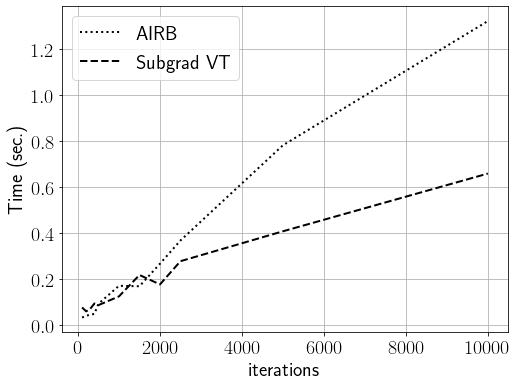

In [16]:
###  Iterations and time
import matplotlib.pyplot as plt

plt.rc("text", usetex=True)
plt.figure(figsize=(8, 6))
fontsize=20

### Data
x = iterations_list

y1 = Time_Algorithm2_AIRB

y2 = Time_Subgrad_VT

plt.xlabel('iterations', fontsize=fontsize)
plt.ylabel('Time (sec.)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)


plt.plot(x,y1, ':' , linewidth=2, color= 'black')  #****
plt.plot(x,y2,'--', linewidth=2, color= 'black')  #****

plt.legend(['AIRB' , 'Subgrad VT'],fontsize=fontsize)  # ***

#plt.xscale('log')
#plt.yscale('log')

plt.grid(1)

plt.show()

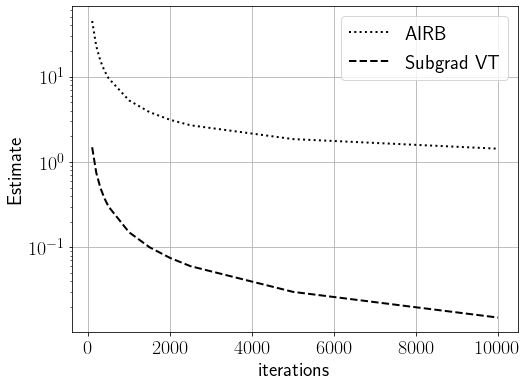

In [17]:
plt.rc("text", usetex=True)
plt.figure(figsize=(8, 6))
fontsize=20

### Data
x = iterations_list

y1 = estimate_Algorithm2_AIRB

y2 = estimate_Subgrad_VT

plt.xlabel('iterations', fontsize=fontsize)
plt.ylabel('Estimate', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)


plt.plot(x,y1, ':' , linewidth=2, color= 'black')  #****
plt.plot(x,y2,'--', linewidth=2, color= 'black')  #****

plt.legend(['AIRB' , 'Subgrad VT'],fontsize=fontsize)  # ***

#plt.xscale('log')
plt.yscale('log')

plt.grid(1)

plt.show()